In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from datetime import datetime

import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from pyts.classification import TimeSeriesForest
from pyts.multivariate.classification import MultivariateClassifier
from sklearn.model_selection import train_test_split
import random

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler


from sklearn.model_selection import GridSearchCV


warnings.filterwarnings("ignore")

## data reading

In [2]:
# Specify the directory path

partition = "partition1"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)

fl_X_data = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    fl_X_data.append(df_interpolated.values)

fl_y_data = np.array(['FL']*len(fl_X_data))
fl_X_data = np.array(fl_X_data)

fl_X_data.shape, fl_y_data.shape

((1254, 60, 5), (1254,))

In [3]:
# Specify the directory path

partition = "partition1"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)


nf_X_data = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data.append(df_interpolated.values)

nf_y_data = np.array(['NF']*len(nf_X_data))
nf_X_data = np.array(nf_X_data)

nf_X_data.shape, nf_y_data.shape

((72238, 60, 5), (72238,))

In [4]:
from collections import Counter
Counter(fl_y_data)

Counter({'FL': 1254})

# Experiment 8

## sample the data

In [24]:
random_indices = random.sample(range(len(nf_X_data)), 1401)

false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
nf_y_subsampled = ['NF']*len(false_class_data_subsampled)

X_train_combined = np.concatenate((fl_X_data, false_class_data_subsampled), axis=0)
y_train_combined = np.concatenate((fl_y_data, nf_y_subsampled))

print(f"\nX Train shape: {X_train_combined.shape}")
print(f"y Train shape: {y_train_combined.shape}")


X Train shape: (2802, 60, 5)
y Train shape: (2802,)


## normalization

In [ ]:
def min_max_normalize_3d(array_train, array_test):
    scaler = MinMaxScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


def zscore_normalize_3d(array_train, array_test):
    scaler = StandardScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


def robust_scale_3d(array_train, array_test):
    scaler = RobustScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


## modeling

In [ ]:
def generating_scores(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    # Calculate Heidke Skill Score (HSS)
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    # Calculate True Skill Statistic (TSS)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TSS = sensitivity + specificity - 1

    return conf_matrix, HSS, TSS

## running 10 times random

In [71]:
def generate_random_sample(fl_X_data, fl_y_data, nf_X_data):
    indices_true_train, indices_true_test = train_test_split(
        np.arange(len(fl_X_data)),
        test_size=0.3,
        random_state=42
    )
    X_true_train = fl_X_data[indices_true_train]
    X_true_test = fl_X_data[indices_true_test]
    y_true_train = fl_y_data[indices_true_train]
    y_true_test = fl_y_data[indices_true_test]

    random_indices = random.sample(range(len(nf_X_data)), 1500)

    false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
    
    indices_false_train, indices_false_test = train_test_split(
        np.arange(len(false_class_data_subsampled)),
        test_size=0.3,
        random_state=42
    )

    X_false_train = false_class_data_subsampled[indices_false_train]
    X_false_test = false_class_data_subsampled[indices_false_test]
    y_false_train = np.array(['NF']*len(indices_false_train))
    y_false_test = np.array(['NF']*len(indices_false_test))

    
    X_train_combined = np.concatenate((X_true_train, X_false_train), axis=0)
    y_train_combined = np.concatenate((y_true_train, y_false_train))
    X_test_combined = np.concatenate((X_true_test, X_false_test), axis=0)
    y_test_combined = np.concatenate((y_true_test, y_false_test))

    return X_train_combined, y_train_combined, X_test_combined, y_test_combined

In [84]:
hss_scores_iterations_raw = []
tss_scores_iterations_raw = []
conf_matrix_iterations_raw = []

hss_scores_iterations_minmax = []
tss_scores_iterations_minmax = []
conf_matrix_iterations_minmax = []

hss_scores_iterations_zscore = []
tss_scores_iterations_zscore = []
conf_matrix_iterations_zscore = []

hss_scores_iterations_robust = []
tss_scores_iterations_robust = []
conf_matrix_iterations_robust = []

for i in range(10):

    print(i, end=" ")

    X_train_combined, y_train_combined, X_test_combined, y_test_combined = generate_random_sample(fl_X_data, fl_y_data, nf_X_data)
    
    # Apply raw data
    clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
    clf.fit(X_train_combined, y_train_combined)
    y_pred = clf.predict(X_test_combined)
    conf_matrix, hss_score, tss_score = generating_scores(y_test_combined, y_pred)

    hss_scores_iterations_raw.append(hss_score)
    tss_scores_iterations_raw.append(tss_score)
    conf_matrix_iterations_raw.append(conf_matrix)
    
    # Apply min-max normalization
    X_train_normalized_data, X_test_normalized_data = min_max_normalize_3d(X_train_combined, X_test_combined)

    clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60))
    clf.fit(X_train_normalized_data, y_train_combined)
    y_pred = clf.predict(X_test_normalized_data)
    conf_matrix, hss_score, tss_score = generating_scores(y_test_combined, y_pred)

    hss_scores_iterations_minmax.append(hss_score)
    tss_scores_iterations_minmax.append(tss_score)
    conf_matrix_iterations_minmax.append(conf_matrix)

   
    # Apply z_score
    X_train_zscore_data, X_test_zscore_data = zscore_normalize_3d(X_train_combined, X_test_combined)

    clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60))
    clf.fit(X_train_zscore_data, y_train_combined)
    y_pred = clf.predict(X_test_zscore_data)
    conf_matrix, hss_score, tss_score = generating_scores(y_test_combined, y_pred)

    hss_scores_iterations_zscore.append(hss_score)
    tss_scores_iterations_zscore.append(tss_score)
    conf_matrix_iterations_zscore.append(conf_matrix)

    # Apply robust scale
    X_train_robustscale_data, X_test_robustscale_data = robust_scale_3d(X_train_combined, X_test_combined)

    clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60))
    clf.fit(X_train_robustscale_data, y_train_combined)
    y_pred = clf.predict(X_test_robustscale_data)
    conf_matrix, hss_score, tss_score = generating_scores(y_test_combined, y_pred)

    hss_scores_iterations_robust.append(hss_score)
    tss_scores_iterations_robust.append(tss_score)
    conf_matrix_iterations_robust.append(conf_matrix)

0 1 2 3 4 5 6 7 8 9 

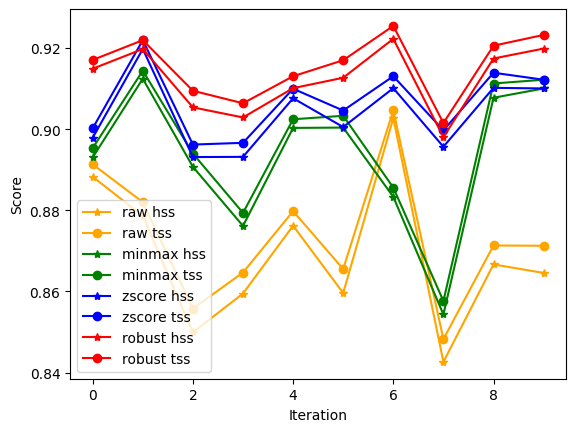

In [85]:
plt.plot(hss_scores_iterations_raw, label='raw hss', marker = "*", color='orange')
plt.plot(tss_scores_iterations_raw, label='raw tss', marker = 'o', color='orange')

plt.plot(hss_scores_iterations_minmax, label='minmax hss', marker = "*", color='g')
plt.plot(tss_scores_iterations_minmax, label='minmax tss', marker = 'o', color='g')

plt.plot(hss_scores_iterations_zscore, label='zscore hss', marker = "*", color='b')
plt.plot(tss_scores_iterations_zscore, label='zscore tss', marker = 'o', color='b')

plt.plot(hss_scores_iterations_robust, label='robust hss', marker = "*", color='r')
plt.plot(tss_scores_iterations_robust, label='robust tss', marker = 'o', color='r')

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()
plt.show()

In [89]:
np.mean(hss_scores_iterations_robust), np.mean(tss_scores_iterations_robust)

(0.9123247395707107, 0.9155608605953433)

## testing on imbalanced dataset

In [ ]:
# Specify the directory path

partition = "partition2"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)


    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 990
(990, 60, 5) (990,)
Number of files in NF: 74375


((74375, 60, 5), (74375,))

In [82]:
X_combined_part2 = np.concatenate((fl_X_data_part2, nf_X_data_part2), axis=0)
y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_data_part2), axis=0)
print(X_combined_part2.shape, y_combined_part2.shape)

(75365, 60, 5) (75365,)


In [83]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(X_train_combined, y_train_combined)

y_pred = clf.predict(X_combined_part2)

conf_matrix, hss_score, tss_score = generating_scores(y_combined_part2, y_pred)

print("HSS: ", hss_score)
print("TSS: ", tss_score)


HSS:  0.21524433885893712
TSS:  0.8589250488074018


In [84]:
# min-max normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_normalized_data, X_combined_normalized_part2 = min_max_normalize_3d(X_train_combined, X_combined_part2)

clf.fit(X_train_normalized_data, y_train_combined)

y_pred = clf.predict(X_combined_normalized_part2)

conf_matrix, hss_score, tss_score = generating_scores(y_combined_part2, y_pred)
    
print("HSS: ", hss_score)
print("TSS: ", tss_score)


HSS:  0.23526303612353672
TSS:  0.7725653170359053


In [85]:
# z-score normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_zscore_data, X_combined_zscore_part2 = zscore_normalize_3d(X_train_combined, X_combined_part2)

clf.fit(X_train_zscore_data, y_train_combined)

y_pred = clf.predict(X_combined_zscore_part2)

conf_matrix, hss_score, tss_score = generating_scores(y_combined_part2, y_pred)
    
print("HSS: ", hss_score)
print("TSS: ", tss_score)

HSS:  0.25850148482022334
TSS:  0.7436318818436467


In [86]:
# robust scaling normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_part2)

clf.fit(X_train_robustscale_data, y_train_combined)

y_pred = clf.predict(X_combined_robustscale_part2)

conf_matrix, hss_score, tss_score = generating_scores(y_combined_part2, y_pred)
    
print("HSS: ", hss_score)
print("TSS: ", tss_score)

HSS:  0.2592512249255173
TSS:  0.7391998641880995


In [87]:
print(boooo)

NameError: name 'boooo' is not defined

## testing on other partitions balanced dataset

In [25]:
# Specify the directory path

partition = "partition1"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 1254
(1254, 60, 5) (1254,)
Number of files in NF: 72238


KeyboardInterrupt: 

In [ ]:

num_datasets = 5
sample_nf_data_points = 1254

sampled_indices_set = set()

X_combined_test_datasets = []
y_combined_test_datasets = []

for i in range(num_datasets):
    nf_random_indices = random.sample(set(range(len(nf_X_data_part2))) - sampled_indices_set, sample_nf_data_points)
    nf_random_X_data_subsampled = np.array([nf_X_data_part2[j] for j in nf_random_indices])
    nf_y_subsampled = np.array(["NF"] * len(nf_random_X_data_subsampled))
    
    X_combined_part2 = np.concatenate((fl_X_data_part2, nf_random_X_data_subsampled), axis=0)
    y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_subsampled), axis=0)
    
    sampled_indices_set.update(nf_random_indices)
    
    # Append combined datasets to the lists
    X_combined_test_datasets.append(X_combined_part2)
    y_combined_test_datasets.append(y_combined_part2)

# Print the shape of each combined dataset
for i in range(num_datasets):
    print(f"Dataset {i+1}: {X_combined_test_datasets[i].shape}, {y_combined_test_datasets[i].shape}")


Dataset 1: (1980, 60, 5), (1980,)
Dataset 2: (1980, 60, 5), (1980,)
Dataset 3: (1980, 60, 5), (1980,)
Dataset 4: (1980, 60, 5), (1980,)
Dataset 5: (1980, 60, 5), (1980,)


In [ ]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(X_train_combined, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(X_combined_test_datasets[i])

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


0 1 2 3 4 
HSS:  0.8565656565656565
TSS:  0.8565656565656565


In [ ]:
# min-max normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_normalized_data, X_combined_normalized_part2 = min_max_normalize_3d(X_train_combined, X_combined_test_datasets[0])

clf.fit(X_train_normalized_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_normalized_data, X_combined_normalized_part2 = min_max_normalize_3d(X_train_combined, X_combined_test_datasets[i])
    y_pred = clf.predict(X_combined_normalized_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

0 1 2 3 4 
HSS:  0.7745454545454545
TSS:  0.7745454545454544


In [ ]:
# z-score normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_zscore_data, X_combined_zscore_part2 = zscore_normalize_3d(X_train_combined, X_combined_test_datasets[0])

clf.fit(X_train_zscore_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_zscore_data, X_combined_zscore_part2 = zscore_normalize_3d(X_train_combined, X_combined_test_datasets[i])

    y_pred = clf.predict(X_combined_zscore_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

0 1 2 3 4 
HSS:  0.7444444444444445
TSS:  0.7444444444444445


In [ ]:
# robust scaling normalized

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[0])

clf.fit(X_train_robustscale_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[i])

    y_pred = clf.predict(X_combined_robustscale_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

0 1 2 3 4 
HSS:  0.7387878787878788
TSS:  0.7387878787878788


In [ ]:
print(boooo)

NameError: name 'boooo' is not defined

## plots

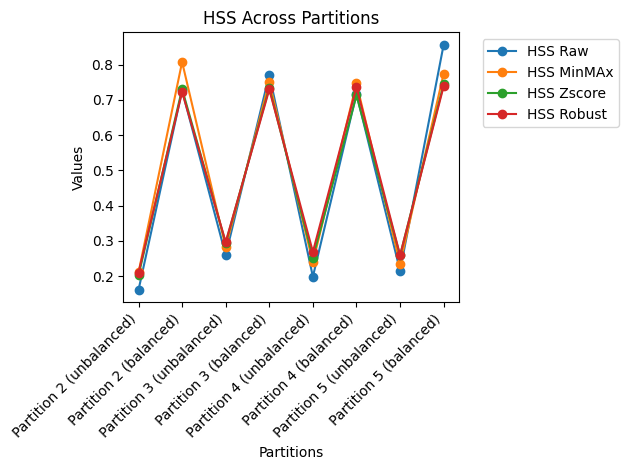

In [91]:
import matplotlib.pyplot as plt
import numpy as np

partitions = ['Partition 2 (unbalanced)', 'Partition 2 (balanced)', 'Partition 3 (unbalanced)',
              'Partition 3 (balanced)', 'Partition 4 (unbalanced)', 'Partition 4 (balanced)',
              'Partition 5 (unbalanced)', 'Partition 5 (balanced)']

hss_values = [0.1608, 0.7264, 0.2595, 0.7712, 0.1985, 0.7169, 0.2152, 0.8565]
tss_values =  [0.7226, 0.7264, 0.7724, 0.7712, 0.7203, 0.7169, 0.8589, 0.8565]

hss_minmax_values = [0.2103, 0.8072, 0.2815, 0.7502, 0.2387, 0.7466, 0.2352, 0.7745]
tss_minmax_values = [0.8065, 0.8072, 0.7538, 0.7502, 0.7504, 0.7466, 0.7725, 0.7745]

hss_zscore_values = [0.2021, 0.7304, 0.2937, 0.7346, 0.2526, 0.7122, 0.2585, 0.7444]
tss_zscore_values = [0.7298, 0.7304, 0.7363, 0.7346, 0.7174, 0.7122, 0.7436, 0.7444]

hss_robust_values = [0.2100, 0.7223, 0.2965, 0.7294, 0.2687, 0.7359, 0.2592, 0.7387]
tss_robust_values = [0.7216, 0.7223, 0.7318, 0.7294, 0.7399, 0.7359, 0.7391, 0.7387]

index = np.arange(len(partitions))

fig, ax = plt.subplots()

# Line plot for HSS
ax.plot(index, hss_values, label='HSS Raw', marker='o')
ax.plot(index, hss_minmax_values, label='HSS MinMAx',  marker='o')
ax.plot(index, hss_zscore_values, label='HSS Zscore', marker='o')
ax.plot(index, hss_robust_values, label='HSS Robust',  marker='o')

# Line plot for TSS
ax.plot(index, tss_values, label='TSS',linestyle='--', marker='*')
ax.plot(index, tss_minmax_values, label='TSS MinMAx', linestyle='--', marker='*')
ax.plot(index, tss_zscore_values, label='TSS Zscore', linestyle='--', marker='*')
ax.plot(index, tss_robust_values, label='TSS Robust', linestyle='--', marker='*')

ax.set_xlabel('Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS Across Partitions')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


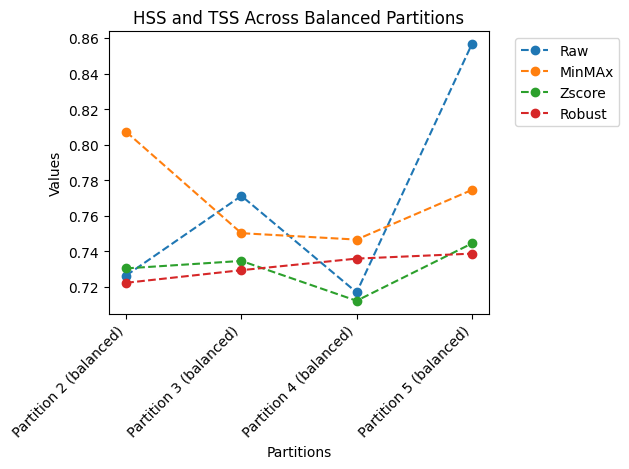

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

partitions = ['Partition 2 (balanced)', 'Partition 3 (balanced)','Partition 4 (balanced)', 'Partition 5 (balanced)']

hss_values = [0.7264, 0.7712, 0.7169, 0.8565]

hss_minmax_values = [0.8072, 0.7502, 0.7466, 0.7745]

hss_zscore_values = [0.7304, 0.7346, 0.7122, 0.7444]
                     
hss_robust_values = [0.7223, 0.7294, 0.7359, 0.7387]

index = np.arange(len(partitions))

fig, ax = plt.subplots()

# Line plot for HSS
ax.plot(index, hss_values, label='Raw',linestyle='--',  marker='o')
ax.plot(index, hss_minmax_values, label='MinMAx',  linestyle='--', marker='o')
ax.plot(index, hss_zscore_values, label='Zscore', linestyle='--', marker='o')
ax.plot(index, hss_robust_values, label='Robust',  linestyle='--', marker='o')


ax.set_xlabel('Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS Across Balanced Partitions')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Experiment 9 - Haar wavelet

### sample the data

In [5]:
random_indices = random.sample(range(len(nf_X_data)), 1254)

false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
nf_y_subsampled = ['NF']*len(false_class_data_subsampled)

X_train_combined = np.concatenate((fl_X_data, false_class_data_subsampled), axis=0)
y_train_combined = np.concatenate((fl_y_data, nf_y_subsampled))

print(f"\nX Train shape: {X_train_combined.shape}")
print(f"y Train shape: {y_train_combined.shape}")


X Train shape: (2508, 60, 5)
y Train shape: (2508,)


### normalization

In [6]:
def robust_scale_3d(array_train, array_test):
    scaler = RobustScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


## modeling

In [7]:
def generating_scores(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    # Calculate Heidke Skill Score (HSS)
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    # Calculate True Skill Statistic (TSS)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TSS = sensitivity + specificity - 1

    return conf_matrix, HSS, TSS

### testing on other partitions balanced dataset

In [8]:
# Specify the directory path

partition = "partition2"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 1401
(1401, 60, 5) (1401,)
Number of files in NF: 87156


KeyboardInterrupt: 

In [ ]:
num_datasets = 5
sample_nf_data_points = len(fl_y_data_part2)

sampled_indices_set = set()

X_combined_test_datasets = []
y_combined_test_datasets = []

for i in range(num_datasets):
    nf_random_indices = random.sample(set(range(len(nf_X_data_part2))) - sampled_indices_set, sample_nf_data_points)
    nf_random_X_data_subsampled = np.array([nf_X_data_part2[j] for j in nf_random_indices])
    nf_y_subsampled = np.array(["NF"] * len(nf_random_X_data_subsampled))
    
    X_combined_part2 = np.concatenate((fl_X_data_part2, nf_random_X_data_subsampled), axis=0)
    y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_subsampled), axis=0)
    
    sampled_indices_set.update(nf_random_indices)
    
    # Append combined datasets to the lists
    X_combined_test_datasets.append(X_combined_part2)
    y_combined_test_datasets.append(y_combined_part2)

# Print the shape of each combined dataset
for i in range(num_datasets):
    print(f"Dataset {i+1}: {X_combined_test_datasets[i].shape}, {y_combined_test_datasets[i].shape}")


Dataset 1: (2802, 60, 5), (2802,)
Dataset 2: (2802, 60, 5), (2802,)
Dataset 3: (2802, 60, 5), (2802,)
Dataset 4: (2802, 60, 5), (2802,)
Dataset 5: (2802, 60, 5), (2802,)


In [163]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(X_train_combined, y_train_combined)
print(X_train_combined.shape)
hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(X_combined_test_datasets[i])

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


(1980, 60, 5)
0 1 2 3 4 
HSS:  0.5490128755364807
TSS:  0.5490128755364807


In [164]:
# robust scaling normalized on raw

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[0])
print(X_train_robustscale_data.shape)
clf.fit(X_train_robustscale_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[i])

    y_pred = clf.predict(X_combined_robustscale_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(1980, 60, 5)
0 1 2 3 4 
HSS:  0.6149356223175966
TSS:  0.6149356223175966


In [55]:
def perform_haar_transformation(signal, lvl):
    coeff = pywt.wavedec(signal, 'haar', level=lvl)
    return coeff



In [56]:
# haar wavelet on raw data
level = 2
clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

coeffs_train = []
for sample in X_train_combined:
    sample_coeffs = []
    for i in range(5):
        coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
        sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
    sample_coeffs = np.array(sample_coeffs).T
    coeffs_train.append(sample_coeffs)

coeffs_train = np.array(coeffs_train)

print(coeffs_train.shape)

clf.fit(coeffs_train, y_train_combined)

hss_scores = []
tss_scores = []

for ind in range(5):
    print(ind, end = " ")

    coeffs_test = []
    for sample in X_combined_test_datasets[ind]:
        sample_coeffs = []
        for i in range(5):
            coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
            sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_test.append(sample_coeffs)
    
    coeffs_test = np.array(coeffs_test)
    
    y_pred = clf.predict(coeffs_test)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)
0 1 2 3 4 
HSS:  0.7446629213483146
TSS:  0.7446629213483146


In [57]:
# robust scaling normalized on haar wavelet

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[0])

#print(X_train_robustscale_data.shape)
coeffs_train = []
for sample in X_train_robustscale_data:
    sample_coeffs = []
    for i in range(5):
        coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
        sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
    sample_coeffs = np.array(sample_coeffs).T
    coeffs_train.append(sample_coeffs)

coeffs_train = np.array(coeffs_train)

print(coeffs_train.shape)

clf.fit(coeffs_train, y_train_combined)

hss_scores = []
tss_scores = []

for ind in range(5):
    #print(ind, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[ind])

    coeffs_test = []
    for sample in X_combined_robustscale_part2:
        sample_coeffs = []
        for i in range(5):
            coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
            sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_test.append(sample_coeffs)
    
    coeffs_test = np.array(coeffs_test)
    #print(coeffs_test.shape)
    y_pred = clf.predict(coeffs_test)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)

    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)

HSS:  0.7563202247191011
TSS:  0.7563202247191012


In [180]:
print(boooo)

NameError: name 'boooo' is not defined

### plots

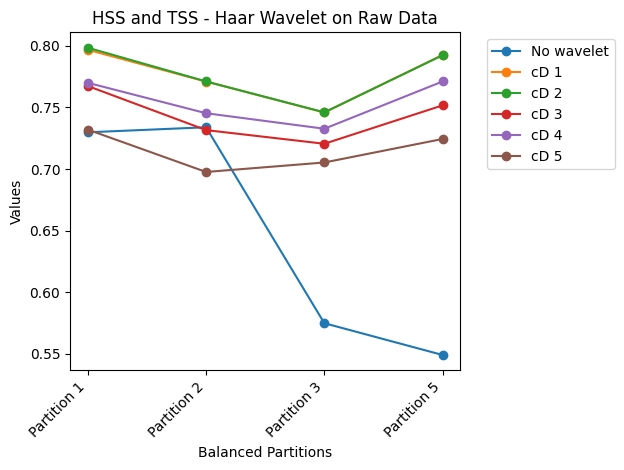

In [181]:
import matplotlib.pyplot as plt
import numpy as np

partitions = [ 'Partition 1',
              'Partition 2', 'Partition 3', 'Partition 5',]

no_wavelet = [0.7298, 0.7339, 0.5748, 0.5490]
cd_1 = [0.7968, 0.7710, 0.7459, 0.7926]
cd_2 = [0.7985, 0.7711, 0.7460, 0.7924]
cd_3 = [0.7674, 0.7316, 0.7205, 0.7517]
cd_4 = [0.7700, 0.7453, 0.7327, 0.7711]
cd_5 = [0.7320, 0.6976, 0.7053, 0.7244]
index = np.arange(len(partitions))

fig, ax = plt.subplots()

# Line plot
ax.plot(index, no_wavelet, label='No wavelet', marker='o')
ax.plot(index, cd_1, label='cD 1',  marker='o',)
ax.plot(index, cd_2, label='cD 2', marker='o',)
ax.plot(index, cd_3, label='cD 3',  marker='o',)
ax.plot(index, cd_4, label='cD 4',  marker='o',)
ax.plot(index, cd_5, label='cD 5',  marker='o',)

ax.set_xlabel('Balanced Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS - Haar Wavelet on Raw Data')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


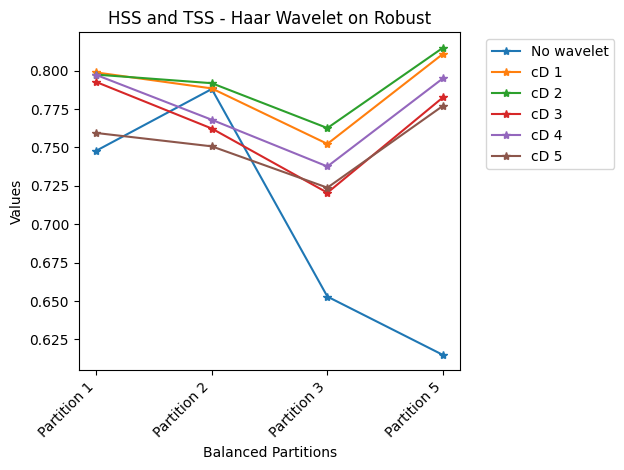

In [182]:
import matplotlib.pyplot as plt
import numpy as np

partitions = [ 'Partition 1',
              'Partition 2', 'Partition 3', 'Partition 5',]

no_wavelet = [0.7478, 0.7880, 0.6529, 0.6149]
cd_1 = [0.7988, 0.7884, 0.7523, 0.8109]
cd_2 = [0.7974, 0.7918, 0.7626, 0.8149]
cd_3 = [0.7926, 0.7623, 0.7205, 0.7826]
cd_4 = [0.7972, 0.7680, 0.7376, 0.7950]
cd_5 = [0.7594, 0.7507, 0.7238, 0.7771]

fig, ax = plt.subplots()


# Line plot
ax.plot(index, no_wavelet, label='No wavelet', marker='*', )
ax.plot(index, cd_1, label='cD 1',  marker='*', )
ax.plot(index, cd_2, label='cD 2', marker='*')
ax.plot(index, cd_3, label='cD 3',  marker='*')
ax.plot(index, cd_4, label='cD 4',  marker='*')
ax.plot(index, cd_5, label='cD 5',  marker='*')

ax.set_xlabel('Balanced Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS - Haar Wavelet on Robust')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


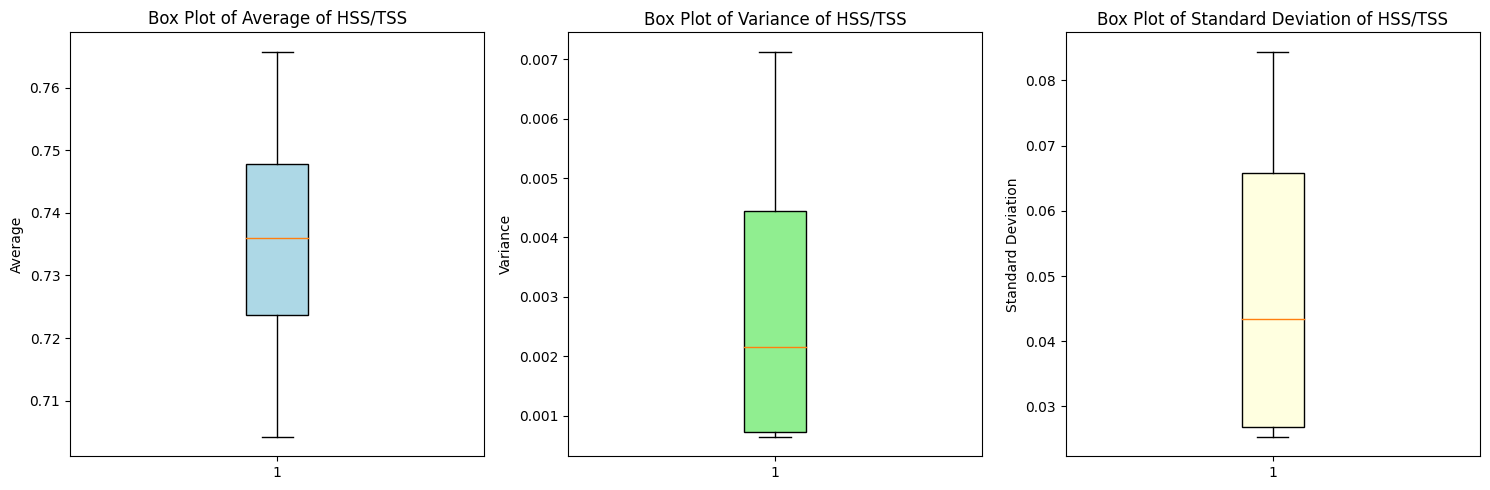

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# Define the partitions
part2 = [0.7298, 0.7968, 0.7985, 0.7674, 0.7700, 0.7320]
part3 = [0.7339, 0.7710, 0.7711, 0.7316, 0.7453, 0.6976]
part4 = [0.5748, 0.7459, 0.7460, 0.7205, 0.7327, 0.7053]
part5 = [0.5490, 0.7926, 0.7924, 0.7517, 0.7711, 0.7244]

# Calculate average, variance, and standard deviation for each partition
averages = [np.mean(part) for part in [part2, part3, part4, part5]]
variances = [np.var(part) for part in [part2, part3, part4, part5]]
std_deviations = [np.std(part) for part in [part2, part3, part4, part5]]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for Average
axs[0].boxplot(averages, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[0].set_title('Box Plot of Average of HSS/TSS')
axs[0].set_ylabel('Average')

# Box plot for Variance
axs[1].boxplot(variances, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Box Plot of Variance of HSS/TSS')
axs[1].set_ylabel('Variance')

# Box plot for Standard Deviation
axs[2].boxplot(std_deviations, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
axs[2].set_title('Box Plot of Standard Deviation of HSS/TSS')
axs[2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


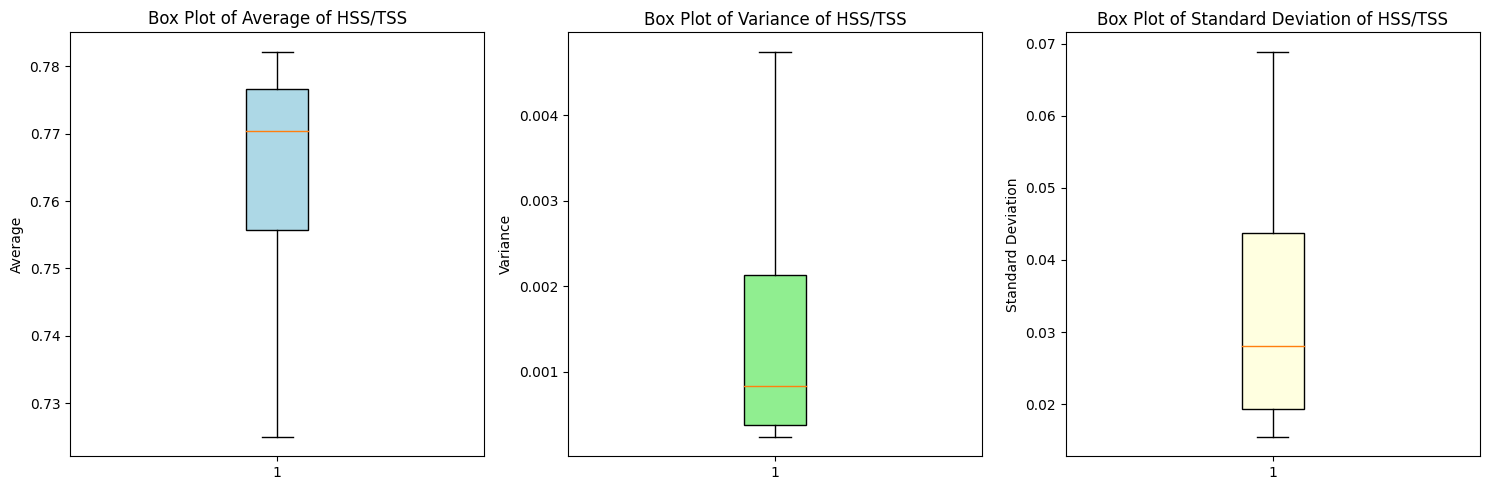

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Define the partitions
part2 = [0.7478, 0.7988, 0.7974, 0.7926, 0.7972, 0.7594]
part3 = [0.7880, 0.7884, 0.7918, 0.7623, 0.7680, 0.7507]
part4 = [0.6529, 0.7523, 0.7626, 0.7205, 0.7376, 0.7238]
part5 = [0.6149, 0.8109, 0.8149, 0.7826, 0.7950, 0.7771]

# Calculate average, variance, and standard deviation for each partition
averages = [np.mean(part) for part in [part2, part3, part4, part5]]
variances = [np.var(part) for part in [part2, part3, part4, part5]]
std_deviations = [np.std(part) for part in [part2, part3, part4, part5]]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for Average
axs[0].boxplot(averages, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[0].set_title('Box Plot of Average of HSS/TSS')
axs[0].set_ylabel('Average')

# Box plot for Variance
axs[1].boxplot(variances, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Box Plot of Variance of HSS/TSS')
axs[1].set_ylabel('Variance')

# Box plot for Standard Deviation
axs[2].boxplot(std_deviations, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
axs[2].set_title('Box Plot of Standard Deviation of HSS/TSS')
axs[2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


# Experiment 18 - Running Average

### sample the data

In [10]:
random_indices = random.sample(range(len(nf_X_data)), 1254)

false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
nf_y_subsampled = ['NF']*len(false_class_data_subsampled)

X_train_combined = np.concatenate((fl_X_data, false_class_data_subsampled), axis=0)
y_train_combined = np.concatenate((fl_y_data, nf_y_subsampled))

print(f"\nX Train shape: {X_train_combined.shape}")
print(f"y Train shape: {y_train_combined.shape}")


X Train shape: (2508, 60, 5)
y Train shape: (2508,)


### normalization

In [11]:
def robust_scale_3d(array_train, array_test):
    scaler = RobustScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


## modeling

In [12]:
def generating_scores(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    # Calculate Heidke Skill Score (HSS)
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    # Calculate True Skill Statistic (TSS)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TSS = sensitivity + specificity - 1

    return conf_matrix, HSS, TSS

### testing on other partitions balanced dataset

In [96]:
# Specify the directory path

partition = "partition5"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 990
(990, 60, 5) (990,)
Number of files in NF: 74375


((74375, 60, 5), (74375,))

In [97]:
num_datasets = 5
sample_nf_data_points = len(fl_y_data_part2)

sampled_indices_set = set()

X_combined_test_datasets = []
y_combined_test_datasets = []

for i in range(num_datasets):
    nf_random_indices = random.sample(set(range(len(nf_X_data_part2))) - sampled_indices_set, sample_nf_data_points)
    nf_random_X_data_subsampled = np.array([nf_X_data_part2[j] for j in nf_random_indices])
    nf_y_subsampled = np.array(["NF"] * len(nf_random_X_data_subsampled))
    
    X_combined_part2 = np.concatenate((fl_X_data_part2, nf_random_X_data_subsampled), axis=0)
    y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_subsampled), axis=0)
    
    sampled_indices_set.update(nf_random_indices)
    
    # Append combined datasets to the lists
    X_combined_test_datasets.append(X_combined_part2)
    y_combined_test_datasets.append(y_combined_part2)

# Print the shape of each combined dataset
for i in range(num_datasets):
    print(f"Dataset {i+1}: {X_combined_test_datasets[i].shape}, {y_combined_test_datasets[i].shape}")


Dataset 1: (1980, 60, 5), (1980,)
Dataset 2: (1980, 60, 5), (1980,)
Dataset 3: (1980, 60, 5), (1980,)
Dataset 4: (1980, 60, 5), (1980,)
Dataset 5: (1980, 60, 5), (1980,)


In [98]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(X_train_combined, y_train_combined)
print(X_train_combined.shape)
hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(X_combined_test_datasets[i])

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


(2508, 60, 5)
0 1 2 3 4 
HSS:  0.8593939393939394
TSS:  0.8593939393939396


In [99]:
# robust scaling normalized on raw

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[0])
print(X_train_robustscale_data.shape)
clf.fit(X_train_robustscale_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[i])

    y_pred = clf.predict(X_combined_robustscale_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 60, 5)
0 1 2 3 4 
HSS:  0.7967676767676768
TSS:  0.7967676767676768


### running avg 4

In [100]:
def calculate_running_averages_4_points(array_2d):
    # Ensure the number of rows is divisible by 4 for this calculation
    if array_2d.shape[0] % 4 != 0:
        raise ValueError("The number of rows should be divisible by 4 for this calculation.")
    
    # Initialize an empty array to store the results
    result = np.zeros((array_2d.shape[0] // 4, array_2d.shape[1]))
    
    # Iterate through each column
    for col in range(array_2d.shape[1]):
        # Calculate the running average for every 4 points
        for i in range(0, array_2d.shape[0], 4):
            result[i // 4, col] = np.mean(array_2d[i:i+4, col])
    
    return result

def apply_running_average_3d(array_3d):
    # Initialize an empty list to store the result for each sample
    results = []
    
    # Iterate through each sample in the 3D array
    for sample in array_3d:
        # Calculate the running averages for the sample
        sample_result = calculate_running_averages_4_points(sample)
        results.append(sample_result)

    results = np.array(results)
    print(results.shape)
    # Convert the list of results into a 3D numpy array
    return results

In [101]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(apply_running_average_3d(X_train_combined), y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(apply_running_average_3d(X_combined_test_datasets[i]))

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


(2508, 15, 5)
0 (1980, 15, 5)
1 (1980, 15, 5)
2 (1980, 15, 5)
3 (1980, 15, 5)
4 (1980, 15, 5)

HSS:  0.8585858585858585
TSS:  0.8585858585858585


In [102]:
# robust scaling normalized on raw

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(apply_running_average_3d(X_train_combined), apply_running_average_3d(X_combined_test_datasets[0]))
print(X_train_robustscale_data.shape)
clf.fit(X_train_robustscale_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(apply_running_average_3d(X_train_combined), apply_running_average_3d(X_combined_test_datasets[i]))

    y_pred = clf.predict(X_combined_robustscale_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)
(1980, 15, 5)
(2508, 15, 5)
0 (2508, 15, 5)
(1980, 15, 5)
1 (2508, 15, 5)
(1980, 15, 5)
2 (2508, 15, 5)
(1980, 15, 5)
3 (2508, 15, 5)
(1980, 15, 5)
4 (2508, 15, 5)
(1980, 15, 5)

HSS:  0.78
TSS:  0.78


### running avg 8

In [103]:
import numpy as np

def pad_array_to_64(array_2d):
    """
    Pad the 2D array with zeros to ensure it has 64 rows.
    """
    rows_to_add = 64 - array_2d.shape[0]
    if rows_to_add > 0:
        padding = np.zeros((rows_to_add, array_2d.shape[1]))
        padded_array = np.vstack((array_2d, padding))
    else:
        padded_array = array_2d
    return padded_array

def calculate_running_averages_8_points(array_2d):
    """
    Calculate the running average of every 8 points for each column in the 2D array.
    """
    # Ensure the array has 64 rows
    if array_2d.shape[0] != 64:
        raise ValueError("The array must have 64 rows for this calculation.")
    
    # Initialize an empty array to store the results
    result = np.zeros((8, array_2d.shape[1]))
    
    # Iterate through each column
    for col in range(array_2d.shape[1]):
        # Calculate the running average for every 8 points
        for i in range(0, array_2d.shape[0], 8):
            result[i // 8, col] = np.mean(array_2d[i:i+8, col])
    
    return result

def apply_running_average_3d_with_padding(array_3d):
    """
    Apply padding and then the running average calculation to each sample in the 3D array.
    """
    results = []
    
    # Iterate through each sample in the 3D array
    for sample in array_3d:
        padded_sample = pad_array_to_64(sample)
        sample_result = calculate_running_averages_8_points(padded_sample)
        results.append(sample_result)

    print(np.array(results).shape)
    
    return np.array(results)


# Apply padding and the running average calculation
running_averages_3d_padded = apply_running_average_3d_with_padding(X_train_combined)
print(running_averages_3d_padded.shape)


(2508, 8, 5)
(2508, 8, 5)


In [104]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(apply_running_average_3d_with_padding(X_train_combined), y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(apply_running_average_3d_with_padding(X_combined_test_datasets[i]))

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


(2508, 8, 5)
0 (1980, 8, 5)
1 (1980, 8, 5)
2 (1980, 8, 5)
3 (1980, 8, 5)
4 (1980, 8, 5)

HSS:  0.8527272727272728
TSS:  0.8527272727272728


In [105]:
# robust scaling normalized on raw

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(apply_running_average_3d_with_padding(X_train_combined), apply_running_average_3d_with_padding(X_combined_test_datasets[0]))
print(X_train_robustscale_data.shape)
clf.fit(X_train_robustscale_data, y_train_combined)

hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(apply_running_average_3d_with_padding(X_train_combined), apply_running_average_3d_with_padding(X_combined_test_datasets[i]))

    y_pred = clf.predict(X_combined_robustscale_part2)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 8, 5)
(1980, 8, 5)
(2508, 8, 5)
0 (2508, 8, 5)
(1980, 8, 5)
1 (2508, 8, 5)
(1980, 8, 5)
2 (2508, 8, 5)
(1980, 8, 5)
3 (2508, 8, 5)
(1980, 8, 5)
4 (2508, 8, 5)
(1980, 8, 5)

HSS:  0.7850505050505051
TSS:  0.7850505050505052


### haar level 2/3

In [112]:
# haar wavelet on raw data
level = 2
clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

coeffs_train = []
for sample in X_train_combined:
    sample_coeffs = []
    for i in range(5):
        coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
        sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
    sample_coeffs = np.array(sample_coeffs).T
    coeffs_train.append(sample_coeffs)

coeffs_train = np.array(coeffs_train)

print(coeffs_train.shape)

clf.fit(coeffs_train, y_train_combined)

hss_scores = []
tss_scores = []

for ind in range(5):
    print(ind, end = " ")

    coeffs_test = []
    for sample in X_combined_test_datasets[ind]:
        sample_coeffs = []
        for i in range(5):
            coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
            sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_test.append(sample_coeffs)
    
    coeffs_test = np.array(coeffs_test)
    
    y_pred = clf.predict(coeffs_test)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)
0 1 2 3 4 
HSS:  0.8313131313131313
TSS:  0.8313131313131313


In [113]:
# robust scaling normalized on haar wavelet

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[0])

#print(X_train_robustscale_data.shape)
coeffs_train = []
for sample in X_train_robustscale_data:
    sample_coeffs = []
    for i in range(5):
        coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
        sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
    sample_coeffs = np.array(sample_coeffs).T
    coeffs_train.append(sample_coeffs)

coeffs_train = np.array(coeffs_train)

print(coeffs_train.shape)

clf.fit(coeffs_train, y_train_combined)

hss_scores = []
tss_scores = []

for ind in range(5):
    #print(ind, end = " ")
    X_train_robustscale_data, X_combined_robustscale_part2 = robust_scale_3d(X_train_combined, X_combined_test_datasets[ind])

    coeffs_test = []
    for sample in X_combined_robustscale_part2:
        sample_coeffs = []
        for i in range(5):
            coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
            sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_test.append(sample_coeffs)
    
    coeffs_test = np.array(coeffs_test)
    #print(coeffs_test.shape)
    y_pred = clf.predict(coeffs_test)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)

    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)

HSS:  0.845858585858586
TSS:  0.845858585858586


### plots

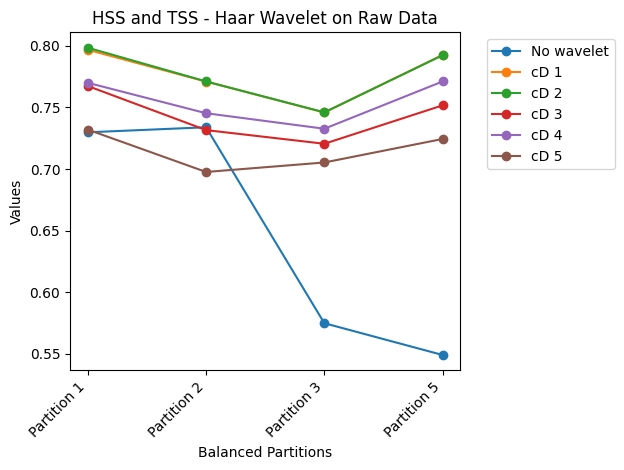

In [108]:
import matplotlib.pyplot as plt
import numpy as np

partitions = [ 'Partition 1',
              'Partition 2', 'Partition 3', 'Partition 5',]

no_wavelet = [0.7298, 0.7339, 0.5748, 0.5490]
cd_1 = [0.7968, 0.7710, 0.7459, 0.7926]
cd_2 = [0.7985, 0.7711, 0.7460, 0.7924]
cd_3 = [0.7674, 0.7316, 0.7205, 0.7517]
cd_4 = [0.7700, 0.7453, 0.7327, 0.7711]
cd_5 = [0.7320, 0.6976, 0.7053, 0.7244]
index = np.arange(len(partitions))

fig, ax = plt.subplots()

# Line plot
ax.plot(index, no_wavelet, label='No wavelet', marker='o')
ax.plot(index, cd_1, label='cD 1',  marker='o',)
ax.plot(index, cd_2, label='cD 2', marker='o',)
ax.plot(index, cd_3, label='cD 3',  marker='o',)
ax.plot(index, cd_4, label='cD 4',  marker='o',)
ax.plot(index, cd_5, label='cD 5',  marker='o',)

ax.set_xlabel('Balanced Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS - Haar Wavelet on Raw Data')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


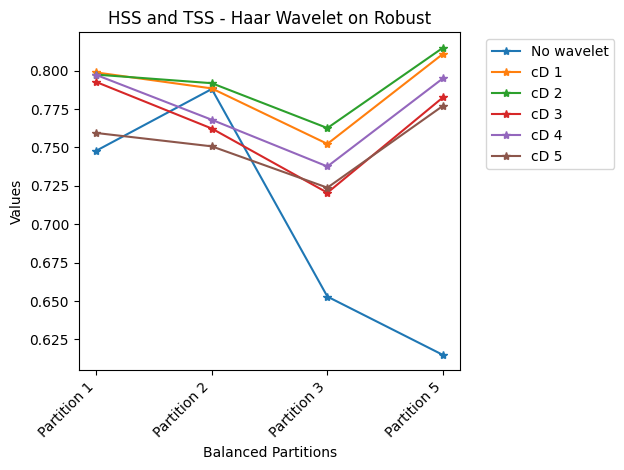

In [109]:
import matplotlib.pyplot as plt
import numpy as np

partitions = [ 'Partition 1',
              'Partition 2', 'Partition 3', 'Partition 5',]

no_wavelet = [0.7478, 0.7880, 0.6529, 0.6149]
cd_1 = [0.7988, 0.7884, 0.7523, 0.8109]
cd_2 = [0.7974, 0.7918, 0.7626, 0.8149]
cd_3 = [0.7926, 0.7623, 0.7205, 0.7826]
cd_4 = [0.7972, 0.7680, 0.7376, 0.7950]
cd_5 = [0.7594, 0.7507, 0.7238, 0.7771]

fig, ax = plt.subplots()


# Line plot
ax.plot(index, no_wavelet, label='No wavelet', marker='*', )
ax.plot(index, cd_1, label='cD 1',  marker='*', )
ax.plot(index, cd_2, label='cD 2', marker='*')
ax.plot(index, cd_3, label='cD 3',  marker='*')
ax.plot(index, cd_4, label='cD 4',  marker='*')
ax.plot(index, cd_5, label='cD 5',  marker='*')

ax.set_xlabel('Balanced Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS - Haar Wavelet on Robust')
ax.set_xticks(index)
ax.set_xticklabels(partitions, rotation=45, ha="right")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


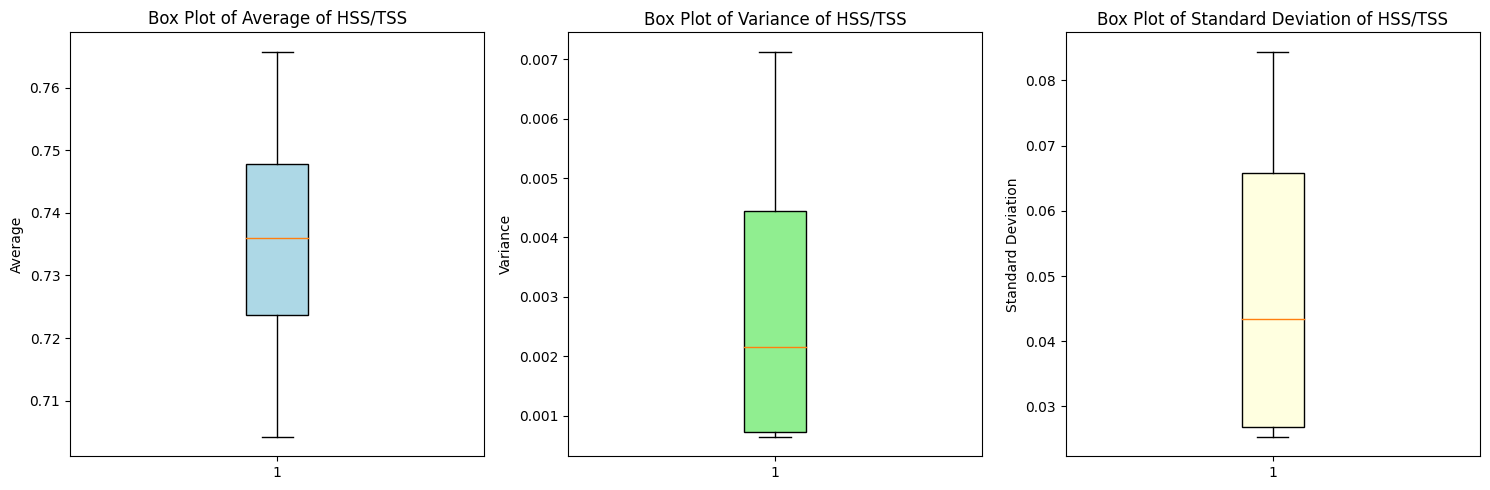

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Define the partitions
part2 = [0.7298, 0.7968, 0.7985, 0.7674, 0.7700, 0.7320]
part3 = [0.7339, 0.7710, 0.7711, 0.7316, 0.7453, 0.6976]
part4 = [0.5748, 0.7459, 0.7460, 0.7205, 0.7327, 0.7053]
part5 = [0.5490, 0.7926, 0.7924, 0.7517, 0.7711, 0.7244]

# Calculate average, variance, and standard deviation for each partition
averages = [np.mean(part) for part in [part2, part3, part4, part5]]
variances = [np.var(part) for part in [part2, part3, part4, part5]]
std_deviations = [np.std(part) for part in [part2, part3, part4, part5]]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for Average
axs[0].boxplot(averages, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[0].set_title('Box Plot of Average of HSS/TSS')
axs[0].set_ylabel('Average')

# Box plot for Variance
axs[1].boxplot(variances, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Box Plot of Variance of HSS/TSS')
axs[1].set_ylabel('Variance')

# Box plot for Standard Deviation
axs[2].boxplot(std_deviations, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
axs[2].set_title('Box Plot of Standard Deviation of HSS/TSS')
axs[2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


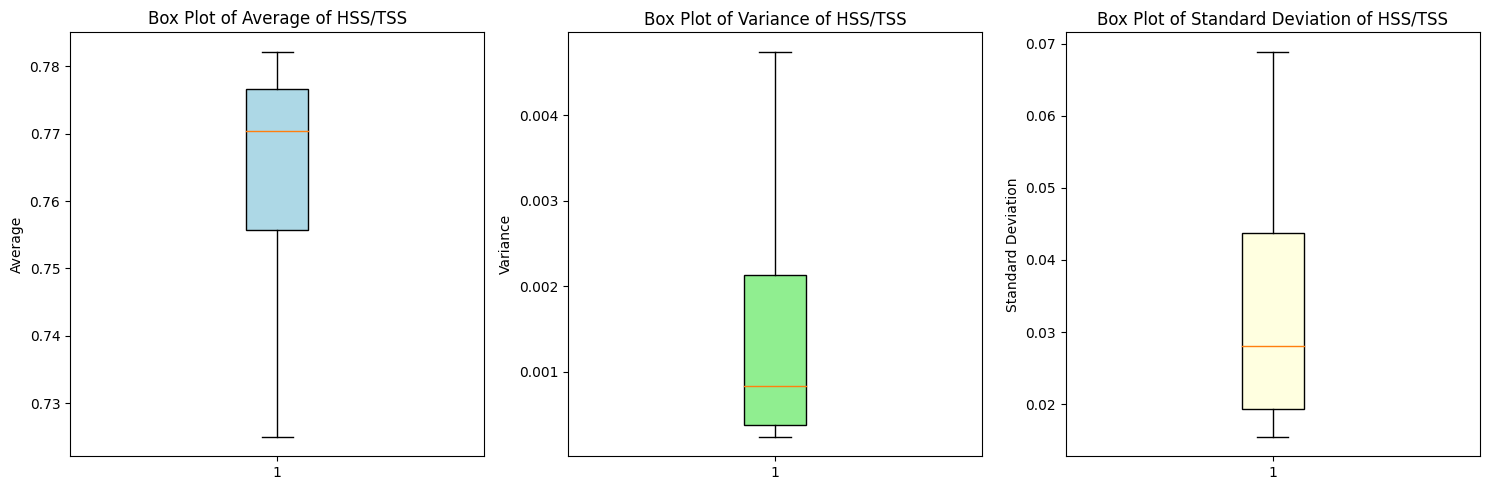

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Define the partitions
part2 = [0.7478, 0.7988, 0.7974, 0.7926, 0.7972, 0.7594]
part3 = [0.7880, 0.7884, 0.7918, 0.7623, 0.7680, 0.7507]
part4 = [0.6529, 0.7523, 0.7626, 0.7205, 0.7376, 0.7238]
part5 = [0.6149, 0.8109, 0.8149, 0.7826, 0.7950, 0.7771]

# Calculate average, variance, and standard deviation for each partition
averages = [np.mean(part) for part in [part2, part3, part4, part5]]
variances = [np.var(part) for part in [part2, part3, part4, part5]]
std_deviations = [np.std(part) for part in [part2, part3, part4, part5]]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for Average
axs[0].boxplot(averages, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[0].set_title('Box Plot of Average of HSS/TSS')
axs[0].set_ylabel('Average')

# Box plot for Variance
axs[1].boxplot(variances, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Box Plot of Variance of HSS/TSS')
axs[1].set_ylabel('Variance')

# Box plot for Standard Deviation
axs[2].boxplot(std_deviations, patch_artist=True, boxprops=dict(facecolor='lightyellow'))
axs[2].set_title('Box Plot of Standard Deviation of HSS/TSS')
axs[2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


# Experiment 19 - Lossy Decomposition

In [9]:
random_indices = random.sample(range(len(nf_X_data)), 1254)

false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
nf_y_subsampled = ['NF']*len(false_class_data_subsampled)

X_train_combined = np.concatenate((fl_X_data, false_class_data_subsampled), axis=0)
y_train_combined = np.concatenate((fl_y_data, nf_y_subsampled))

print(f"\nX Train shape: {X_train_combined.shape}")
print(f"y Train shape: {y_train_combined.shape}")


X Train shape: (2508, 60, 5)
y Train shape: (2508,)


### normalization

In [10]:
def robust_scale_3d(array_train, array_test):
    scaler = RobustScaler()

    train_reshaped_data = array_train.reshape(-1, array_train.shape[2])
    train_normalized_data = scaler.fit_transform(train_reshaped_data)
    train_normalized_data_3d = train_normalized_data.reshape(array_train.shape)

    test_reshaped_data = array_test.reshape(-1, array_test.shape[2])
    test_normalized_data = scaler.transform(test_reshaped_data)
    test_normalized_data_3d = test_normalized_data.reshape(array_test.shape)

    return train_normalized_data_3d, test_normalized_data_3d


## modeling

In [11]:
def generating_scores(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    # Calculate Heidke Skill Score (HSS)
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    # Calculate True Skill Statistic (TSS)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TSS = sensitivity + specificity - 1

    return conf_matrix, HSS, TSS

### testing on other partitions balanced dataset

In [50]:
# Specify the directory path

partition = "partition2"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 1401
(1401, 60, 5) (1401,)
Number of files in NF: 87156


((87156, 60, 5), (87156,))

In [51]:
num_datasets = 5
sample_nf_data_points = len(fl_y_data_part2)

sampled_indices_set = set()

X_combined_test_datasets = []
y_combined_test_datasets = []

for i in range(num_datasets):
    nf_random_indices = random.sample(set(range(len(nf_X_data_part2))) - sampled_indices_set, sample_nf_data_points)
    nf_random_X_data_subsampled = np.array([nf_X_data_part2[j] for j in nf_random_indices])
    nf_y_subsampled = np.array(["NF"] * len(nf_random_X_data_subsampled))
    
    X_combined_part2 = np.concatenate((fl_X_data_part2, nf_random_X_data_subsampled), axis=0)
    y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_subsampled), axis=0)
    
    sampled_indices_set.update(nf_random_indices)
    
    # Append combined datasets to the lists
    X_combined_test_datasets.append(X_combined_part2)
    y_combined_test_datasets.append(y_combined_part2)

# Print the shape of each combined dataset
for i in range(num_datasets):
    print(f"Dataset {i+1}: {X_combined_test_datasets[i].shape}, {y_combined_test_datasets[i].shape}")


Dataset 1: (2802, 60, 5), (2802,)
Dataset 2: (2802, 60, 5), (2802,)
Dataset 3: (2802, 60, 5), (2802,)
Dataset 4: (2802, 60, 5), (2802,)
Dataset 5: (2802, 60, 5), (2802,)


In [52]:
# raw data

clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))
clf.fit(X_train_combined, y_train_combined)
print(X_train_combined.shape)
hss_scores = []
tss_scores = []

for i in range(5):
    print(i, end = " ")
    y_pred = clf.predict(X_combined_test_datasets[i])

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[i], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))


(2508, 60, 5)
0 1 2 3 4 
HSS:  0.712062812276945
TSS:  0.712062812276945


## Haar wavelet

In [53]:
def lossy_decomposition(signal, threshold, mode, level):
    coeffs = pywt.wavedec(signal, 'haar', level=level)
    thresholded_coeffs = [pywt.threshold(c, threshold, mode=mode) for c in coeffs]
    return thresholded_coeffs 

def lossy_reconstruction(coeffs):
    reconstructed_signal = pywt.waverec(coeffs, 'haar')
    return reconstructed_signal

In [54]:
def perform_haar_transformation(signal, lvl):
    coeff = pywt.wavedec(signal, 'haar', level=lvl)
    return coeff

In [55]:
# haar wavelet on raw data

level = 2
clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

coeffs_train = []
for sample in X_train_combined:
    sample_coeffs = []
    for i in range(5):
        coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
        sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
    sample_coeffs = np.array(sample_coeffs).T
    coeffs_train.append(sample_coeffs)

coeffs_train = np.array(coeffs_train)

print(coeffs_train.shape)

clf.fit(coeffs_train, y_train_combined)

hss_scores = []
tss_scores = []

for ind in range(5):
    print(ind, end = " ")

    coeffs_test = []
    for sample in X_combined_test_datasets[ind]:
        sample_coeffs = []
        for i in range(5):
            coeff= perform_haar_transformation(sample[:, i], lvl=level)  # Assuming perform_haar_transformation returns both cA and cD
            sample_coeffs.append(coeff[-level])  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_test.append(sample_coeffs)
    
    coeffs_test = np.array(coeffs_test)
    
    y_pred = clf.predict(coeffs_test)

    conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)
    
    hss_scores.append(hss_score)
    tss_scores.append(tss_score)

print("\nHSS: ", np.mean(hss_scores))
print("TSS: ", np.mean(tss_scores))

(2508, 15, 5)
0 1 2 3 4 
HSS:  0.7684511063526054
TSS:  0.7684511063526054


In [56]:

# haar wavelet with lossy and reconstruction

level = 2

for thresh in [10,20,30]:
    clf = MultivariateClassifier(TimeSeriesForest(n_estimators=150, max_depth=None, min_window_size=1, n_windows = 60, random_state=25))

    coeffs_train = []
    for sample in X_train_combined:
        sample_coeffs = []
        for i in range(5):
            coeff_lossy = lossy_decomposition(sample[:, i], thresh , 'hard',level=level)  # Assuming perform_haar_transformation returns both cA and cD
            coeff_recons = lossy_reconstruction(coeff_lossy)
            sample_coeffs.append(coeff_recons)  # Assuming you want to append only detail coefficients
        sample_coeffs = np.array(sample_coeffs).T
        coeffs_train.append(sample_coeffs)

    coeffs_train = np.array(coeffs_train)

    print(coeffs_train.shape)

    clf.fit(coeffs_train, y_train_combined)

    hss_scores = []
    tss_scores = []

    for ind in range(5):
        print(ind, end = " ")

        coeffs_test = []
        for sample in X_combined_test_datasets[ind]:
            sample_coeffs = []
            for i in range(5):
                coeff_lossy = lossy_decomposition(sample[:, i], thresh , 'hard',level=level)  # Assuming perform_haar_transformation returns both cA and cD
                coeff_recons = lossy_reconstruction(coeff_lossy)
                sample_coeffs.append(coeff_recons)  # Assuming you want to append only detail coefficients
            sample_coeffs = np.array(sample_coeffs).T
            coeffs_test.append(sample_coeffs)
        
        coeffs_test = np.array(coeffs_test)
        
        y_pred = clf.predict(coeffs_test)

        conf_matrix, hss_score, tss_score = generating_scores(y_combined_test_datasets[ind], y_pred)
        
        hss_scores.append(hss_score)
        tss_scores.append(tss_score)

    print(f"\n{thresh}")
    print("\nHSS: ", np.mean(hss_scores))
    print("TSS: ", np.mean(tss_scores))

(2508, 60, 5)
0 1 2 3 4 
10

HSS:  0.7097787294789436
TSS:  0.7097787294789436
(2508, 60, 5)
0 1 2 3 4 
20

HSS:  0.7117773019271949
TSS:  0.7117773019271949
(2508, 60, 5)
0 1 2 3 4 
30

HSS:  0.7099214846538187
TSS:  0.7099214846538187
